### Constants

In [45]:
DEPARTURE = 'LEMD'
DESTINATIONS = [
  'LEAS',
  'LEBB',
  'LEBL',
  'LECO',
  'LEGR',
  'LEJR'
]

FLIGHTS_PATH = 'data/flights'
FLIGHTS_POINTS_PATH = 'data/flight_points'

METHOD = 'silhouette'
GRAPHS_PATH = f'results/graphs/trajectories/{METHOD}'

In [2]:
from src.pipeline import build_pipeline

data_pipeline = build_pipeline(flights_path = FLIGHTS_PATH, 
                               flights_points_path = FLIGHTS_POINTS_PATH, 
                               departure = DEPARTURE, 
                               destinations = DESTINATIONS)

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

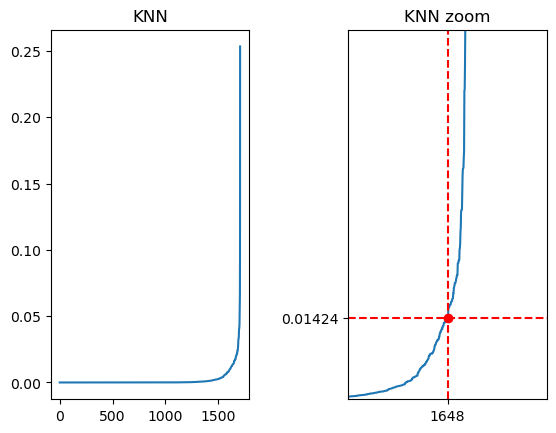

In [46]:
from utils.graphs import show_elbow_plot
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

line = np.linspace(distances[0], distances[-1], len(distances))
distances_to_line = np.abs(distances - line)
elbow_index = np.argmax(distances_to_line)

show_elbow_plot(distances, elbow_index, f'{GRAPHS_PATH}/elbow_sspd.png')

In [47]:
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.array([distances[elbow_index]]),
  "min_samples": np.arange(2, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                              params  clusters  outliers   
0    {'eps': 0.014240121506947414, 'min_samples': 5}        23       116  \
1    {'eps': 0.014240121506947414, 'min_samples': 4}        27        95   
2    {'eps': 0.014240121506947414, 'min_samples': 3}        31        83   
3    {'eps': 0.014240121506947414, 'min_samples': 6}        19       138   
4    {'eps': 0.014240121506947414, 'min_samples': 7}        19       139   
5    {'eps': 0.014240121506947414, 'min_samples': 8}        19       139   
6    {'eps': 0.014240121506947414, 'min_samples': 9}        18       151   
7   {'eps': 0.014240121506947414, 'min_samples': 10}        17       162   
8   {'eps': 0.014240121506947414, 'min_samples': 15}        16       190   
9   {'eps': 0.014240121506947414, 'min_samples': 11}        16       172   
10  {'eps': 0.014240121506947414, 'min_samples': 12}        16       172   
11  {'eps': 0.014240121506947414, 'min_samples': 14}        17       174   
12  {'eps': 

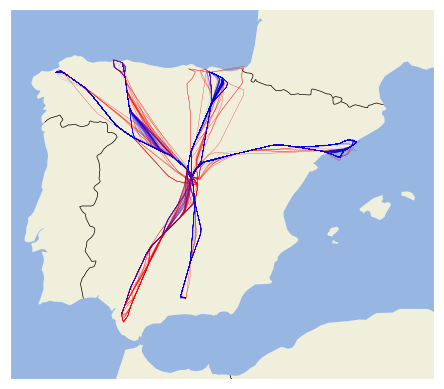

In [48]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_dbscan.png')

### HDBSCAN

In [49]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = { 
    "min_samples": np.arange(1, 16),
    "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         9        18  \
1    {'min_samples': 2, 'min_cluster_size': 100}         9        18   
2    {'min_samples': 3, 'min_cluster_size': 100}         9        18   
3    {'min_samples': 4, 'min_cluster_size': 100}         9        18   
4    {'min_samples': 5, 'min_cluster_size': 100}         9        18   
5    {'min_samples': 6, 'min_cluster_size': 100}         9        18   
6    {'min_samples': 7, 'min_cluster_size': 100}         9        18   
7    {'min_samples': 8, 'min_cluster_size': 100}         9        18   
8    {'min_samples': 9, 'min_cluster_size': 100}         9        18   
9   {'min_samples': 10, 'min_cluster_size': 100}         9        18   
10  {'min_samples': 11, 'min_cluster_size': 100}         9        18   
11  {'min_samples': 12, 'min_cluster_size': 100}         9        18   
12  {'min_samples': 13, 'min_cluster_size': 100}         9      

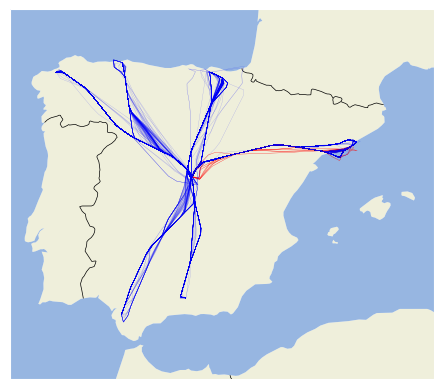

In [50]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

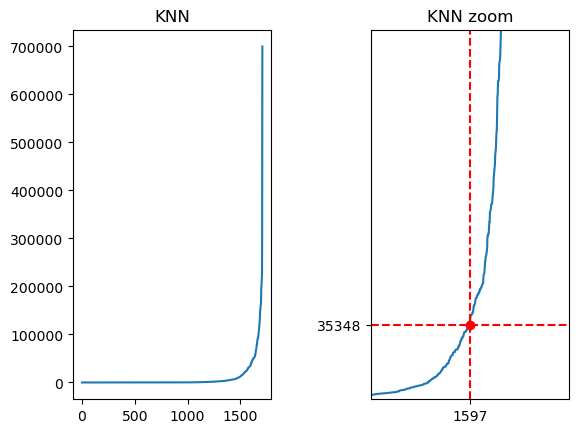

In [51]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

line = np.linspace(distances[0], distances[-1], len(distances))
distances_to_line = np.abs(distances - line)
elbow_index = np.argmax(distances_to_line)

show_elbow_plot(distances, elbow_index, f'{GRAPHS_PATH}/elbow_erp.png')

In [52]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.array([distances[elbow_index]]),
  "min_samples": np.arange(2, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                            params  clusters  outliers   
0    {'eps': 35348.478151237825, 'min_samples': 3}        39       142  \
1    {'eps': 35348.478151237825, 'min_samples': 4}        33       163   
2    {'eps': 35348.478151237825, 'min_samples': 5}        30       179   
3    {'eps': 35348.478151237825, 'min_samples': 2}        54       112   
4    {'eps': 35348.478151237825, 'min_samples': 6}        26       203   
5    {'eps': 35348.478151237825, 'min_samples': 7}        26       212   
6    {'eps': 35348.478151237825, 'min_samples': 8}        24       227   
7    {'eps': 35348.478151237825, 'min_samples': 9}        22       243   
8   {'eps': 35348.478151237825, 'min_samples': 10}        20       266   
9   {'eps': 35348.478151237825, 'min_samples': 11}        19       277   
10  {'eps': 35348.478151237825, 'min_samples': 12}        18       295   
11  {'eps': 35348.478151237825, 'min_samples': 13}        17       313   
12  {'eps': 35348.478151237825, 'min_s

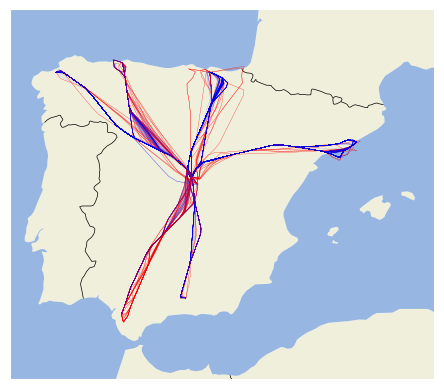

In [53]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_dbscan.png')

### HDBSCAN

In [54]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(erp_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         9         8  \
1    {'min_samples': 1, 'min_cluster_size': 120}         9         8   
2    {'min_samples': 2, 'min_cluster_size': 100}         9         9   
3    {'min_samples': 2, 'min_cluster_size': 120}         9         9   
4    {'min_samples': 3, 'min_cluster_size': 100}         9         9   
5    {'min_samples': 3, 'min_cluster_size': 120}         9         9   
6    {'min_samples': 4, 'min_cluster_size': 100}         9        11   
7    {'min_samples': 5, 'min_cluster_size': 100}         9        11   
8   {'min_samples': 11, 'min_cluster_size': 100}         9        14   
9   {'min_samples': 13, 'min_cluster_size': 100}         9        14   
10   {'min_samples': 9, 'min_cluster_size': 100}         9        14   
11  {'min_samples': 12, 'min_cluster_size': 100}         9        13   
12  {'min_samples': 10, 'min_cluster_size': 100}         9      

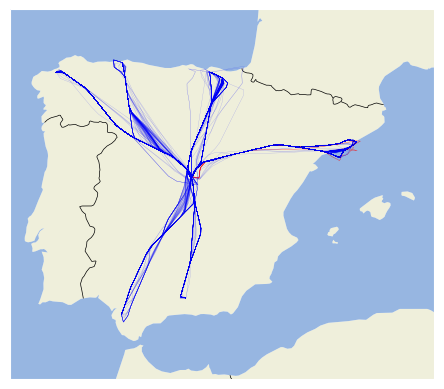

In [55]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)


show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_hdbscan.png')